In [305]:
#Import libraries

import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
import h5py
from scipy.sparse.linalg import lsqr
import tifffile


In [306]:
#Functions used for HDR, configured for IR-VIVO data (16-bit, single channel, max value = 5200)
def matrix_inverse_float32(matrix):
    # Convert input to float32
    matrix = np.array(matrix, dtype=np.float32)
    
    # Check if matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix must be square")
    
    # Get the dimensions of the matrix
    n = matrix.shape[0]
    
    # Create an identity matrix of the same size
    identity = np.eye(n, dtype=np.float32)
    
    # Augment the original matrix with the identity matrix
    augmented = np.concatenate((matrix, identity), axis=1)
    
    # Gaussian elimination
    for i in range(n):
        # Find pivot
        pivot = augmented[i, i]
        if pivot == 0:
            raise ValueError("Matrix is singular and cannot be inverted")
        
        # Divide row by pivot
        augmented[i] = augmented[i] / pivot
        
        # Eliminate column
        for j in range(n):
            if i != j:
                augmented[j] -= augmented[i] * augmented[j, i]
    
    # Extract inverse from the right side of augmented matrix
    inverse = augmented[:, n:]
    
    return inverse

def linearWeight(pixel_value):
    """ Linear weighting function based on pixel intensity that reduces the
    weight of pixel values that are near saturation.

    Parameters
    ----------
    pixel_value : np.uint16
        A pixel intensity value from 0 to 5200

    Returns
    -------
    weight : np.float32
        The weight corresponding to the input pixel intensity

    """
    z_min, z_max = 0., 5200.
    if pixel_value <= (z_min + z_max) / 2:
        return pixel_value - z_min
    return z_max - pixel_value


def sampleIntensities(images):
    """Randomly sample pixel intensities from the exposure stack.

    Parameters
    ----------
    images : list<numpy.ndarray>
        A list containing a stack of single-channel (i.e., grayscale)
        layers of an HDR exposure stack

    Returns
    -------
    intensity_values : numpy.array, dtype=np.uint8
        An array containing a uniformly sampled intensity value from each
        exposure layer (shape = num_intensities x num_images)

    """
    z_min, z_max = 0, 5200
    num_intensities = z_max - z_min + 1
    num_images = len(images)
    intensity_values = np.zeros((num_intensities, num_images), dtype=np.float64)

    # Find the middle image to use as the source for pixel intensity locations
    mid_img = images[num_images // 2]
    print(num_images//2)

    for i in range(z_min, z_max + 1):
        rows, cols = np.where(mid_img == i)
        if len(rows) != 0:
            idx = random.randrange(len(rows))
            for j in range(num_images):
                intensity_values[i, j] = images[j,rows[idx], cols[idx]]
    print(intensity_values == 0)
    intensity_values[intensity_values == 0] = np.nan
    return intensity_values


def computeResponseCurve(intensity_samples, log_exposures, smoothing_lambda, weighting_function):
    """Find the camera response curve for a single color channel

    Parameters
    ----------
    intensity_samples : numpy.ndarray
        Stack of single channel input values (num_samples x num_images)

    log_exposures : numpy.ndarray
        Log exposure times (size == num_images)

    smoothing_lambda : float
        A constant value used to correct for scale differences between
        data and smoothing terms in the constraint matrix -- source
        paper suggests a value of 100.

    weighting_function : callable
        Function that computes a weight from a pixel intensity

    Returns
    -------
    numpy.ndarray, dtype=np.float32
        Return a vector g(z) where the element at index i is the log exposure
        of a pixel with intensity value z = i (e.g., g[0] is the log exposure
        of z=0, g[1] is the log exposure of z=1, etc.)
    """
    z_min, z_max = 0, 5200
    intensity_range = z_max - z_min  # difference between min and max possible pixel value for uint8
    num_samples = intensity_samples.shape[0]
    num_images = len(log_exposures)


    # NxP + [(Zmax-1) - (Zmin + 1)] + 1 constraints; N + 256 columns
    mat_A = np.zeros((num_images * num_samples + intensity_range, num_samples + intensity_range + 1), dtype=np.float32)
    mat_b = np.zeros((mat_A.shape[0], 1), dtype=np.float32)

    # 1. Add data-fitting constraints:
    k = 0
    for i in range(num_samples):
        for j in range(num_images):
            z_ij = intensity_samples[i, j]
            print (["z ij = ",z_ij])
            w_ij = int(weighting_function(z_ij))
            print (["w ij = ",w_ij])
            mat_A[k, z_ij] = w_ij
            mat_A[k, (intensity_range + 1) + i] = -w_ij
            mat_b[k, 0] = w_ij * log_exposures[j]
            k += 1
    #print(z_ij)
    #print(w_ij)
    


    # 2. Add smoothing constraints:
    for z_k in range(z_min + 1, z_max):
        w_k = int(weighting_function(z_k))
        mat_A[k, z_k - 1] = w_k * smoothing_lambda
        mat_A[k, z_k    ] = -2 * w_k * smoothing_lambda
        mat_A[k, z_k + 1] = w_k * smoothing_lambda
        k += 1
    #print(mat_A)
    #print(mat_b)

    # 3. Add color curve centering constraint:
    mat_A[k, (z_max - z_min) // 2] = 1

    def pinv_vector(v):
        return lsqr(mat_A, v)[0]
    def iterative_pinv(A, tol=1e-6, max_iter=1000):
        A = A.astype(np.float32)
        m, n = A.shape
        At = A.T.astype(np.float32)
    
        if m >= n:
            X = At / (np.linalg.norm(A, axis=0)**2 + tol)
        else:
            X = At / (np.linalg.norm(A, axis=1)**2 + tol)[:, np.newaxis]
    
        I = np.eye(m, dtype=np.float32)
    
        for _ in range(max_iter):
            X_old = X.copy()
            X = X + (I - A @ X) @ At @ (X @ X.T)
            if np.linalg.norm(X - X_old) < tol:
                break
    
        return X
    #inv_A = np.float32(iterative_pinv(mat_A))
    inv_A = np.linalg.pinv(mat_A)
    x = np.dot(inv_A, mat_b)

    g = x[0: intensity_range + 1]
    return g[:, 0]


def computeRadianceMap(images, log_exposure_times, response_curve, weighting_function):
    """Calculate a radiance map for each pixel from the response curve.

    Parameters
    ----------
    images : list
        Collection containing a single color layer (i.e., grayscale)
        from each image in the exposure stack. (size == num_images)

    log_exposure_times : numpy.ndarray
        Array containing the log exposure times for each image in the
        exposure stack (size == num_images)

    response_curve : numpy.ndarray
        Least-squares fitted log exposure of each pixel value z

    weighting_function : callable
        Function that computes the weights

    Returns
    -------
    numpy.ndarray(dtype=np.float32)
        The image radiance map (in log space)
    """
    img_shape = images[0].shape
    img_rad_map = np.zeros(img_shape, dtype=np.float32)

    num_images = len(images)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            g = np.array([response_curve[images[k][i, j]] for k in range(num_images)])
            w = np.array([weighting_function(images[k][i, j]) for k in range(num_images)])
            SumW = np.sum(w)
            if SumW > 0:
                img_rad_map[i, j] = np.sum(w * (g - log_exposure_times) / SumW)
            else:
                img_rad_map[i, j] = g[num_images // 2] - log_exposure_times[num_images // 2]
    return img_rad_map


def globalToneMapping(image, gamma):
    """Global tone mapping using gamma correction
    ----------
    images : <numpy.ndarray>
        Image needed to be corrected
    gamma : floating number
        The number for gamma correction. Higher value for brighter result; lower for darker
    Returns
    -------
    numpy.ndarray
        The resulting image after gamma correction
    """
    image_corrected = cv2.pow(image/255., 1.0/gamma)
    return image_corrected


def intensityAdjustment(image, template):
    """Tune image intensity based on template
        ----------
        images : <numpy.ndarray>
            image needed to be adjusted
        template : <numpy.ndarray>
            Typically we use the middle image from image stack. We want to match the image
            intensity for each channel to template's
        Returns
        -------
        numpy.ndarray
            The resulting image after intensity adjustment
        """
    m, n, channel = image.shape
    output = np.zeros((m, n, channel))
    for ch in range(channel):
        image_avg, template_avg = np.average(image[:, :, ch]), np.average(template[:, :, ch])
        output[..., ch] = image[..., ch] * (template_avg / image_avg)

    return output


def computeHDR(images, log_exposure_times, smoothing_lambda=100., gamma=0.6):
    """Computational pipeline to produce the HDR images
    ----------
    images : list<numpy.ndarray>
        A list containing an exposure stack of images
    log_exposure_times : numpy.ndarray
        The log exposure times for each image in the exposure stack
    smoothing_lambda : np.int (Optional)
        A constant value to correct for scale differences between
        data and smoothing terms in the constraint matrix -- source
        paper suggests a value of 100.
    Returns
    -------
    numpy.ndarray
        The resulting HDR with intensities scaled to fit uint8 range
    """

    num_channels = images[0].shape[2]
    hdr_image = np.zeros(images[0].shape, dtype=np.float32)

    for channel in range(num_channels):
        # Collect the current layer of each input image from the exposure stack
        layer_stack = [img[:, :, channel] for img in images]

        # Sample image intensities
        intensity_samples = sampleIntensities(layer_stack)

        # Compute Response Curve
        response_curve = computeResponseCurve(intensity_samples, log_exposure_times, smoothing_lambda, linearWeight)

        # Build radiance map
        img_rad_map = computeRadianceMap(layer_stack, log_exposure_times, response_curve, linearWeight)

        # Normalize hdr layer to (0, 255)
        hdr_image[..., channel] = cv2.normalize(img_rad_map, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Global tone mapping
    image_mapped = globalToneMapping(hdr_image, gamma)

    # Adjust image intensity based on the middle image from image stack
    template = images[len(images)//2]
    image_tuned = intensityAdjustment(image_mapped, template)

    # Output image
    output = cv2.normalize(image_tuned, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return output.astype(np.uint8)

In [307]:
# Change working directories
#Data location
directory = Path('/Users/apate/OneDrive - Northeastern University/Dennis Lab site/Image processing/IR VIVO data/AMD/240329_Water_immersed')
#Path to save data
workingPath = Path('/Users/apate/OneDrive - Northeastern University/Dennis Lab site/BU Research Drive Data/Amish/Imaging and Processing/Coding/Spectral demixing/notebooks/240614_HDR_example')
here = Path(workingPath)
os.chdir(here)
os.chmod(here, 0o755)

#Experiment title
experiment_title = 'Water_immersed'

In [308]:
#Define wavelength and filter names
laser_wavelengths = {'1': '670', '2': '760', '3': '808'}
emission_filters = {'12': 'BP1150', '13': 'BP1200', '14': 'BP1250', '15': 'BP1300', '16': 'BP1350', '17': 'BP1575'}

# Get the list of darkcount files
darkcount_files = [f for f in os.listdir(directory) if f.startswith('darkcounts')]
darkcount_files.sort(key=lambda x: float(x[10:-3]))

# Initialize a dictionary to store the image file lists
image_files = {}

# Get the list of image files for each parameter combination
for laser_key, laser_value in laser_wavelengths.items():
    for filter_key, filter_value in emission_filters.items():
        key = f"{experiment_title}_{laser_value}_{filter_value}"
        image_files[key] = [f for f in os.listdir(directory) if f.startswith(f"{experiment_title}_{laser_key}_{filter_key}")]
        image_files[key].sort(key=lambda x: float(x.split('_')[-1][:-3]))

# Read the darkcount files and store the data
darkcount_data = []
exposure_times = []
for file in darkcount_files:
    file_path = os.path.join(directory, file)
    with h5py.File(file_path, 'r') as h5f:
        darkcount = h5f['Cube']['Images'][()]
        exposure_time = h5f['Cube']['TimeExposure'][()].item()
        darkcount_data.append(darkcount)
        exposure_times.append(exposure_time)

# Concatenate the darkcount data into an array with dimensions (num_exposure_times, height, width)
darkcount_array = np.squeeze(np.array(darkcount_data))

# Convert exposure_times to a NumPy array
exposure_times = np.squeeze(np.array(exposure_times))

# Read the image files and store the data for each parameter combination
image_arrays = {}
for key, files in image_files.items():
    image_data = []
    for file in files:
        file_path = os.path.join(directory, file)
        with h5py.File(file_path, 'r') as h5f:
            image = h5f['Cube']['Images'][()]
            image_data.append(image)
    image_arrays[key] = np.squeeze(np.array(image_data))

# Calculate the mean and standard deviation of pixel intensities for each exposure time in the darkcount cube
darkcount_mean = np.mean(darkcount_array[:, :, :], axis=(1, 2))
darkcount_std = np.std(darkcount_array[:, :, :], axis=(1, 2))
print(darkcount_mean)
print(darkcount_std)

# Convert the image arrays to NumPy arrays for further processing
for key in image_arrays.keys():
    image_arrays[key] = np.array(image_arrays[key])

# Print the shapes of the arrays
print("Darkcount array shape:", darkcount_array.shape)
print("Exposure times array shape:", exposure_times.shape)
print(exposure_times)
for key in image_arrays.keys():
    print(f"Image array shape for {key}:", image_arrays[key].shape)

[ 799.21032715  964.28184509 1061.37977295 1094.0200592  1105.97271118
 1123.6138031  1137.19124756 1152.92250977 1169.57583618 1184.83742676
 1205.35088806 1236.3617218  1280.04559631 1353.41764221 1498.27137451]
[12.86297416 13.12020853 13.37192913 13.52632673 13.71151908 13.73150302
 13.7205852  13.56561546 13.3067028  13.20703569 13.33763676 13.98644368
 15.13072328 16.61922603 18.79814508]
Darkcount array shape: (15, 640, 512)
Exposure times array shape: (15,)
[1.0000e-04 2.0000e-04 4.0000e-04 8.0000e-04 1.6000e-03 3.2000e-03
 6.4000e-03 1.2800e-02 2.5600e-02 5.1200e-02 1.0240e-01 2.0480e-01
 4.0960e-01 8.1920e-01 1.6384e+00]
Image array shape for Water_immersed_670_BP1150: (15, 640, 512)
Image array shape for Water_immersed_670_BP1200: (15, 640, 512)
Image array shape for Water_immersed_670_BP1250: (15, 640, 512)
Image array shape for Water_immersed_670_BP1300: (15, 640, 512)
Image array shape for Water_immersed_670_BP1350: (15, 640, 512)
Image array shape for Water_immersed_670_

In [309]:
#Save image arrays as .npy files

    
for key in image_arrays.keys():
    images = image_arrays[key]
      # Assuming 'keys' is a dictionary with tags for each key
    filename = f"{here}\\{key}.npy"
    print(filename)
    np.save(filename, images)

\Users\apate\OneDrive - Northeastern University\Dennis Lab site\BU Research Drive Data\Amish\Imaging and Processing\Coding\Spectral demixing\notebooks\240614_HDR_example\Water_immersed_670_BP1150.npy
\Users\apate\OneDrive - Northeastern University\Dennis Lab site\BU Research Drive Data\Amish\Imaging and Processing\Coding\Spectral demixing\notebooks\240614_HDR_example\Water_immersed_670_BP1200.npy
\Users\apate\OneDrive - Northeastern University\Dennis Lab site\BU Research Drive Data\Amish\Imaging and Processing\Coding\Spectral demixing\notebooks\240614_HDR_example\Water_immersed_670_BP1250.npy
\Users\apate\OneDrive - Northeastern University\Dennis Lab site\BU Research Drive Data\Amish\Imaging and Processing\Coding\Spectral demixing\notebooks\240614_HDR_example\Water_immersed_670_BP1300.npy
\Users\apate\OneDrive - Northeastern University\Dennis Lab site\BU Research Drive Data\Amish\Imaging and Processing\Coding\Spectral demixing\notebooks\240614_HDR_example\Water_immersed_670_BP1350.npy


(15, 640, 512)
910 5073
2
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 ...
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


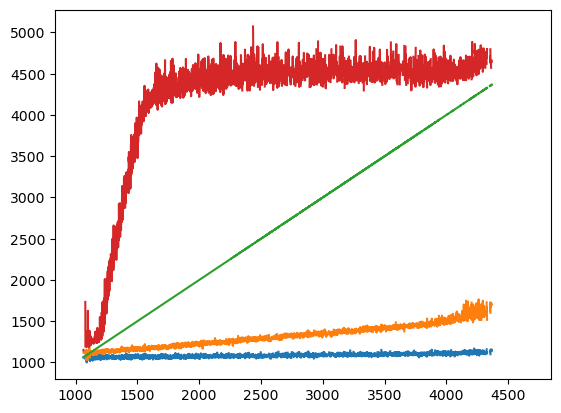

In [310]:
#Load test file

rawdata = np.load("Water_immersed_760_BP1300.npy")
print(rawdata.shape)

#slice d

rawdata = rawdata[[2,5,8,11], 0:640, 0:512]
exposures = exposure_times[[2,5,8,11]]
print(np.amin(rawdata), np.amax(rawdata))

#sample intensities

imageIntensities=sampleIntensities(rawdata)

for idx in range(0,len(exposures)):
    plt.plot(np.arange(0,5201),np.squeeze(imageIntensities[:,idx]))

In [311]:
#Compute response function

responseCurve = computeResponseCurve(imageIntensities, np.log(np.float32(exposures)), 100, linearWeight)



['z ij = ', nan]


ValueError: cannot convert float NaN to integer

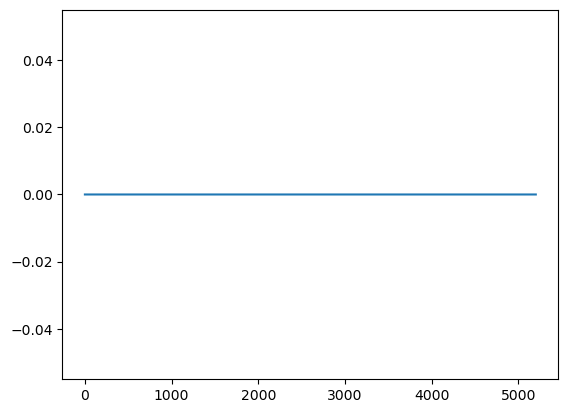

In [241]:
plt.plot(np.arange(0,5201),responseCurve)

In [242]:
#Create radiance map
computeRadianceMap(rawdata, np.log(np.float32(exposures)), responseCurve, linearWeight)

array([[4.5701346, 4.5546117, 4.559216 , ..., 4.578567 , 4.5880184,
        4.561419 ],
       [4.5585823, 4.574223 , 4.555713 , ..., 4.565712 , 4.5598593,
        4.5505414],
       [4.561786 , 4.5458145, 4.544375 , ..., 4.5951643, 4.5770183,
        4.5749187],
       ...,
       [4.5709906, 4.5827374, 4.585766 , ..., 4.581458 , 4.571586 ,
        4.604076 ],
       [4.603334 , 4.5620713, 4.5633616, ..., 4.590361 , 4.5477614,
        4.585557 ],
       [4.6036444, 4.594679 , 4.577309 , ..., 4.6034365, 4.5762563,
        4.5631547]], dtype=float32)

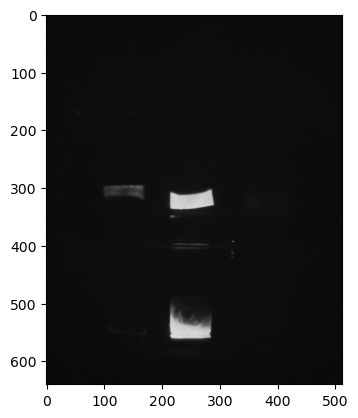

In [243]:
#Gamma correction (optional)

HDRimage = np.squeeze(globalToneMapping(image, 1).astype(np.float32))

#Intensity adjustment

#HDRimage = intensityAdjustment(HDRimage, image)

#Save image
np.save(f"{here}\\HDRimage", HDRimage) #save float32 image as numpy array
tifffile.imwrite(f"{here}\\HDRimage.tif", HDRimage, photometric='minisblack') #save float32 image as tiff
plt.imshow(HDRimage, cmap='gray')
